In [1]:
import json
import urllib
import warnings
import pandas as pd
from tqdm import tqdm 
from itertools import product
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as MAPE

warnings.filterwarnings('ignore')

In [2]:
PC = '#FF3B2B'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [3]:
def retrieve_data(DS,DE):

  """Extract data using wikimedia api"""

  with urllib.request.urlopen(f'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/all-access/all-agents/daily/{DS}/{DE}') as url:
    data = json.loads(url.read().decode())

  data = pd.DataFrame(data['items'])[['timestamp','views']]
  data.timestamp = data.timestamp.apply(lambda x:x[0:-2])
  data.timestamp = pd.DatetimeIndex(data.timestamp)
  data.set_index('timestamp',inplace=True)
  data.index.name = None

  data['views'] = data['views']/1e6

  return data

In [4]:
data = retrieve_data('2010010100','2022043000')

In [5]:
data.shape

(2496, 1)

In [6]:
data.head()

,views
2015-07-01,264.542787
2015-07-02,270.340050
2015-07-03,253.265588
2015-07-04,253.088829
2015-07-05,266.057125


In [7]:
data.to_csv("../Datasets/wiki_views_2010010100_2022043000.csv")

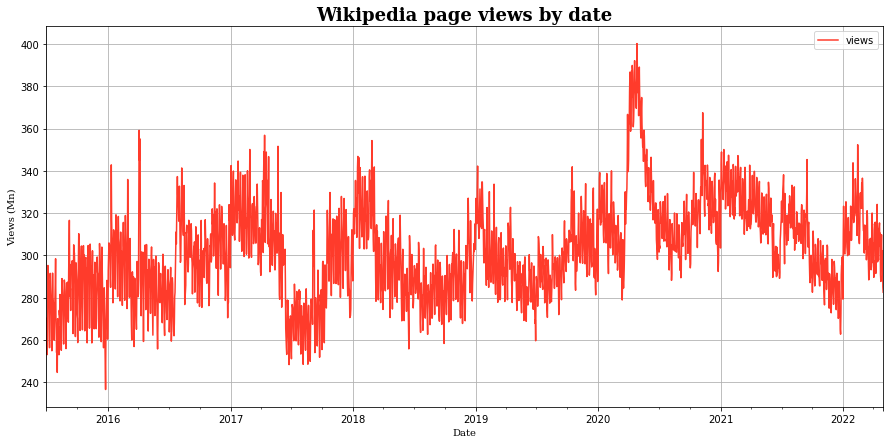

In [8]:
ax = data.plot(figsize=(15,7),color=PC,alpha=1.0)
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia page views by date", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

## ARIMA modeling 
In ARIMA modeling, we need to know properties of the time series. ARIMA models recommended when our series's statistical properties does not change over time.

Here is the few assumptions of ARIMA models,

- That the time-series involved are weakly stationary or Integrated of some order (which implies restrictions on the values of the unknown coefficients, as well as their constancy).

 - That all observed time series are combinations of white noises only, and perhaps a constant.

 - There are no other predictors (in which case you would have an "ARIMA-X" model) and,

 - The relations are exclusively linear (to indicate the possibility of non-linear modelling, you should abbreviate to "NARIMA").

We can use ADFullar test to determine if given time series is stationary or not.

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y,color='black',alpha=0.6)
        p_value = adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value),
            fontsize=17,fontweight='semibold',fontfamily='serif'
        )
        plot_acf(y, lags=lags, ax=acf_ax,color=PC)
        plot_pacf(y, lags=lags, ax=pacf_ax,color=PC)
        plt.tight_layout()

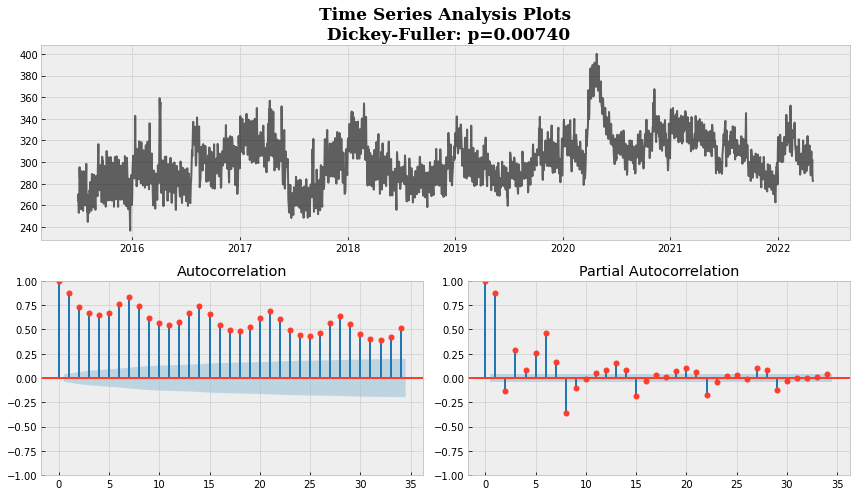

In [10]:
tsplot(data.views)

As per the Augmented Dickey Fuller Test (ADF Test), we can say given time series model is non-stationary. Or other words it includes some seasonality and(or) trend, which is obivous thing in website pag/article views.

To remove that seasonality and pattern and convert it into a stationary, we can use some deferrencing technique or logging techniques.

As per the Autocorrelation plot above, we can say this time series highy seasonal with 7 day time window. Let's try to remove 7 day time window effect using deferencing method.

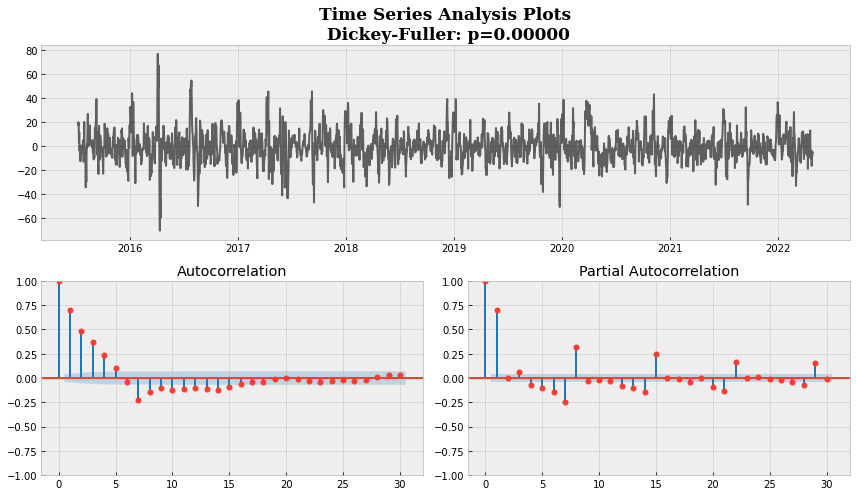

In [11]:
data_diff = data.views - data.views.shift(7)
tsplot(data_diff[7:], lags=30)

Seems okay now, but still series highly correlated with 1D lag, let's try to remove one day lag from deferenced dataset.

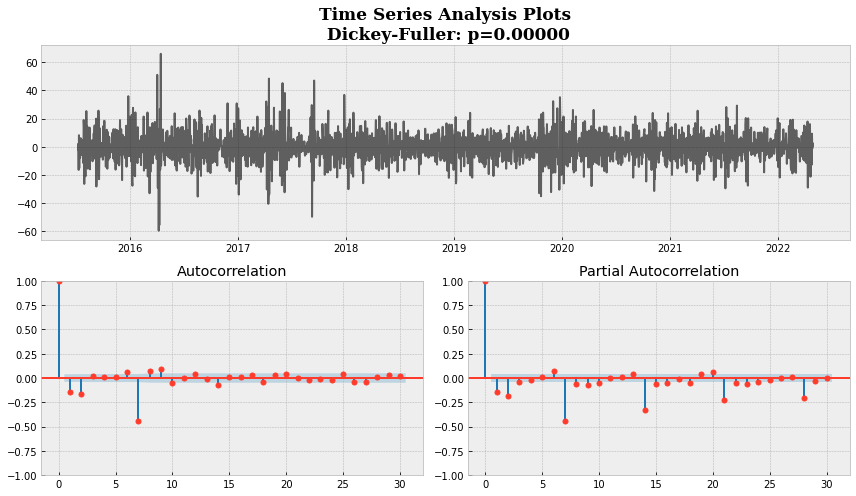

In [12]:
data_diff = data_diff - data_diff.shift(1)
tsplot(data_diff[7 + 1 :], lags=30)

In [13]:
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [14]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        try:
            model = SARIMAX(
                data.views,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table,best_param

In [15]:
%time result_table,params = optimizeSARIMA(parameters_list, d, D, s)

100%|██████████| 36/36 [03:29<00:00,  5.82s/it]

CPU times: total: 3min 20s
Wall time: 3min 29s


In [18]:
train = data.iloc[0:2475]
test = data.iloc[2475:]
params

(2, 4, 1, 1)

In [19]:
p, q, P, Q = params

best_model = SARIMAX(
    train.views, order=(p, d, q), seasonal_order=(P, D, Q, s)
).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               views   No. Observations:                 2475
Model:             SARIMAX(2, 1, 4)x(1, 1, [1], 7)   Log Likelihood               -8372.385
Date:                             Sun, 01 May 2022   AIC                          16762.770
Time:                                     08:01:26   BIC                          16815.067
Sample:                                 07-01-2015   HQIC                         16781.769
                                      - 04-09-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0423      0.018     -2.323      0.020      -0.078      -0.007
ar.L2          0.9448      

Lets plot residual distribution for our best model

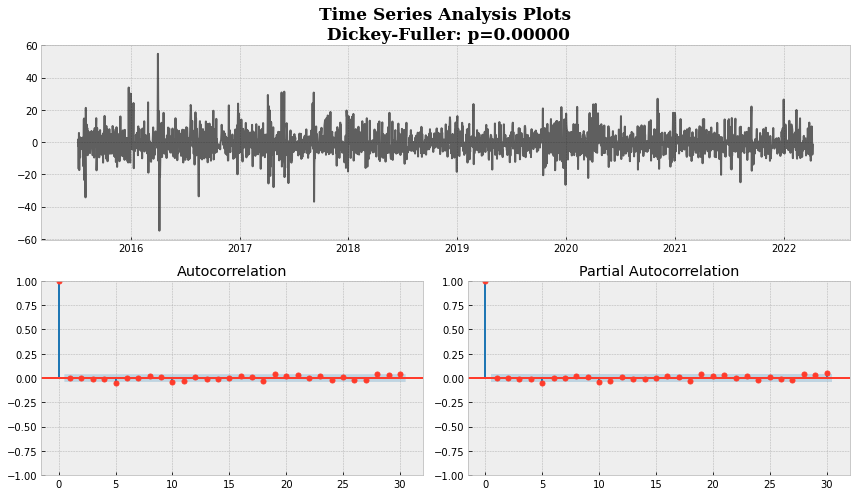

In [20]:
tsplot(best_model.resid[7 + 1 :], lags=30)

It's clear that there are no signals remain in the dataset. Its a pure white noise.

In [21]:
predictions = best_model.predict(start=min(test.index),end=max(test.index))

In [22]:
def plot_predictions(observed,predicted):

    error = "{0:.3f}%".format(MAPE(observed,predicted)*100)

    plt.figure(figsize=(15,7))
    plt.plot(observed,color='black',label='oberved')
    plt.plot(predicted,color=PC,label='predicted')
    plt.legend(loc='upper center')
    plt.xlabel("Date",fontfamily='serif')
    plt.ylabel("Views (Mn)",fontfamily='serif')
    plt.title(f"Predictions vs Observed\nMAPE={error}", fontsize=18,fontweight='semibold',fontfamily='serif')
    plt.grid(True)
    plt.show()

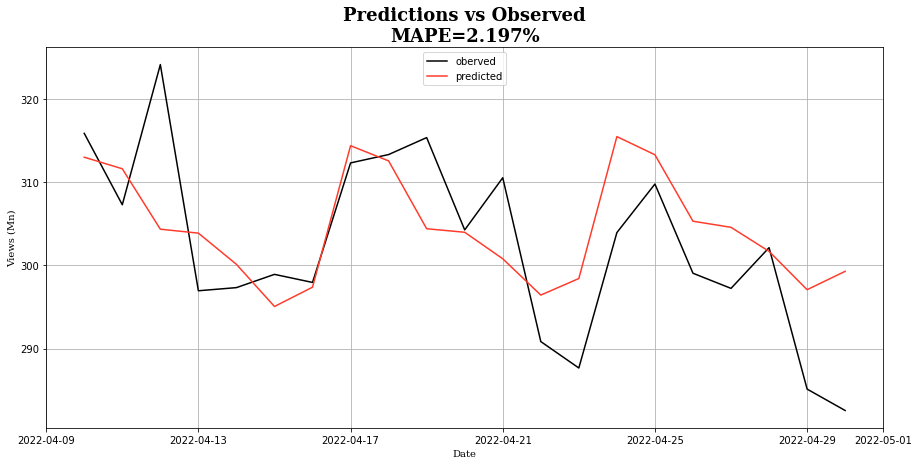

In [23]:
plot_predictions(test,predictions)